In [ ]:
import os

def build_depth_map(super_path):
    depth_map_path = {}

    # Walk through the directory tree
    for root, _, files in os.walk(super_path):
        for filename in files:
            if filename.endswith('.png'):
                full_path = os.path.join(root, filename)
                # Remove super_path from the full path to get the relative path
                relative_path = os.path.relpath(full_path, super_path)
                # Split the relative path into parts (folders)
                parts = relative_path.split(os.sep)
                parts[-1]=parts[-1][len('result_merged_depth_'):-len('.png')]
                
                # Initialize nested dictionaries as needed
                current_dict = depth_map_path
                for part in parts[:-1]:  # Iterate over all parts except the last one (filename)
                    current_dict = current_dict.setdefault(part, {})
                
                # Assign the full path to the deepest nested dictionary
                current_dict[parts[-1]] = full_path

    return depth_map_path

def build_depth_map_confidence(super_path):
    depth_map_path = {}

    # Walk through the directory tree
    for root, _, files in os.walk(super_path):
        for filename in files:
            if filename.endswith('.exr'):
                full_path = os.path.join(root, filename)
                # Remove super_path from the full path to get the relative path
                relative_path = os.path.relpath(full_path, super_path)
                # Split the relative path into parts (folders)
                parts = relative_path.split(os.sep)
                parts[-1]=parts[-1][len('result_merged_conf_'):-len('.exr')]
                
                # Initialize nested dictionaries as needed
                current_dict = depth_map_path
                for part in parts[:-1]:  # Iterate over all parts except the last one (filename)
                    current_dict = current_dict.setdefault(part, {})
                
                # Assign the full path to the deepest nested dictionary
                current_dict[parts[-1]] = full_path

    return depth_map_path



In [ ]:
import os

def find_train_folders(directory):
    train_folders = []
    for root, dirs, files in os.walk(directory):
        for dir in dirs:
            if dir.startswith('train'):
                train_folders.append(os.path.join(root, dir))
    return train_folders

train_path=find_train_folders('/mnt/Velocity Vault/Personal/Projects/Python/Autofocus/Train/')

depth_map_path={}
depth_map_path_temp={}

for path in train_path:
    depth_map_path_temp=build_depth_map(path+"/merged_depth")
    depth_map_path.update(depth_map_path_temp)

depth_map_confidence_path={}
depth_map_confidence_path_temp={}

for path in train_path:
    depth_map_confidence_path_temp=build_depth_map_confidence(path+"/merged_conf")
    depth_map_confidence_path.update(depth_map_confidence_path_temp)




import pprint
pprint.pprint(depth_map_path)
pprint.pprint(depth_map_confidence_path)


In [ ]:
import numpy as np
import random

def generate_random_patches(size=(504,378)):
    image=np.zeros(size)
    patches=[]
    for _ in (range(100)):
        x=random.randint(16, 487)
        y=random.randint(16, 361)

        #print(x,y)
        
        breaker=False

        for i in range(x-26,x+26):
            for j in range(y-26,y+26):
                if i<0 or i>503 or j<0 or j>377 :
                    continue
                if image[i][j]==1:
                    breaker=True
                    break
            if breaker:
                break

        if breaker:
            continue
        
        x=x-16
        y=y-16

        for i in range(x,x+33):
            for j in range(y,y+33):
                image[i][j]=1

        patches.append((x,y))


    return patches

In [ ]:
patch_conf_list=[]

In [ ]:
import numpy as np
import cv2
import OpenEXR
import Imath

def load_exr(file_path):
    exr_file = OpenEXR.InputFile(file_path)
    header = exr_file.header()
    dw = header['dataWindow']
    width = dw.max.x - dw.min.x + 1
    height = dw.max.y - dw.min.y + 1
    pt = Imath.PixelType(Imath.PixelType.FLOAT)
    r = np.frombuffer(exr_file.channel('R', pt), dtype=np.float32)
    r.shape = (height, width)
    return r

def predict_focal_length(depth_map_path,depth_confidence_path):
    depth_map = cv2.imread(depth_map_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
    depth_map_confidence = load_exr(depth_confidence_path)

    patches=generate_random_patches()

    confidence_patch_blocks=[depth_map_confidence[x:x+32,y:y+32] for (x,y) in patches]
    median_confidence_patch_block=[np.median(patch.flatten()) for patch in confidence_patch_blocks]

    patch_conf_list.append(sorted(median_confidence_patch_block, reverse=True)[:4])

    patch_index=median_confidence_patch_block.index(max(median_confidence_patch_block))
    patch=patches[patch_index]

    depth_values=depth_map[patch[0]:patch[0]+32,patch[1]:patch[1]+32]
    depth_values=depth_values.flatten()

    # Define max and min values
    max_depth = 100.0
    min_depth = 0.2

    depth_map_in_meters = (max_depth * min_depth) / (max_depth - (max_depth - min_depth) * (depth_values / 255.0))

    # Compute the median value in the entire depth map
    median_depth = np.median(depth_map_in_meters)

    final_focus=median_depth*1000

    return (final_focus,patch)

slice_focal_length=[3910.92,2289.27,1508.71,1185.83,935.91,801.09,700.37,605.39,546.23,486.87,447.99,407.40,379.91,350.41,329.95,307.54,291.72,274.13,261.53,247.35,237.08,225.41,216.88,207.10,198.18,191.60,183.96,178.29,171.69,165.57,160.99,155.61,150.59,146.81,142.35,138.98,134.99,131.23,127.69,124.99,121.77,118.73,116.40,113.63,110.99,108.47,106.54,104.23,102.01]

def find_closest(value, num_list):
    closest_value = min(num_list, key=lambda x: abs(x - value))
    return closest_value

def predict_slice(depth_map_path,depth_confidence_path):
    output=predict_focal_length(depth_map_path,depth_confidence_path)
    predicted_focus=output[0]
    patch=output[1]
    closest_value = find_closest(predicted_focus, slice_focal_length)
    true_slice=slice_focal_length.index(closest_value)
    return (true_slice,patch)

In [ ]:
# import numpy as np
# import cv2
# import OpenEXR
# import Imath

# def load_exr(file_path):
#     exr_file = OpenEXR.InputFile(file_path)
#     header = exr_file.header()
#     dw = header['dataWindow']
#     width = dw.max.x - dw.min.x + 1
#     height = dw.max.y - dw.min.y + 1
#     pt = Imath.PixelType(Imath.PixelType.FLOAT)
#     r = np.frombuffer(exr_file.channel('R', pt), dtype=np.float32)
#     r.shape = (height, width)
#     return r

# def depth_value_to_focal_length(depth_value):
#     # Define max and min values
#     max_depth = 100.0
#     min_depth = 0.2

#     depth_in_metre = (max_depth * min_depth) / (max_depth - (max_depth - min_depth) * (depth_value / 255.0))

#     focus=depth_in_metre*1000

#     return focus

# def predict_focal_length(depth_map_path,depth_confidence_path):
#     depth_map = cv2.imread(depth_map_path, cv2.IMREAD_GRAYSCALE).astype(np.float32)
#     depth_map_confidence = load_exr(depth_confidence_path)

#     patches=generate_random_patches()

#     depth_map_blocks=[depth_map[x:x+32,y:y+32] for (x,y) in patches]
#     median_depth_map=[np.median(patch.flatten()) for patch in depth_map_blocks]
#     confidence_patch_blocks=[depth_map_confidence[x:x+32,y:y+32] for (x,y) in patches]
#     median_confidence_patch_block=[np.median(patch.flatten()) for patch in confidence_patch_blocks]

#     focai=[depth_value_to_focal_length(depth) for depth in median_depth_map]

#     if sum(median_confidence_patch_block) != 0:
#         predict=sum([value*conf for value,conf in zip(focai,median_confidence_patch_block)])/sum(median_confidence_patch_block)
#     else:
#         predict=np.median(focai)

#     focus=find_closest(predict,median_depth_map)
#     patch_index=median_depth_map.index(focus)
#     patch=patches[patch_index]

#     return (focus,patch)

# slice_focal_length=[3910.92,2289.27,1508.71,1185.83,935.91,801.09,700.37,605.39,546.23,486.87,447.99,407.40,379.91,350.41,329.95,307.54,291.72,274.13,261.53,247.35,237.08,225.41,216.88,207.10,198.18,191.60,183.96,178.29,171.69,165.57,160.99,155.61,150.59,146.81,142.35,138.98,134.99,131.23,127.69,124.99,121.77,118.73,116.40,113.63,110.99,108.47,106.54,104.23,102.01]

# def find_closest(value, num_list):
#     closest_value = min(num_list, key=lambda x: abs(x - value))
#     return closest_value

# def predict_slice(depth_map_path,depth_confidence_path):
#     output=predict_focal_length(depth_map_path,depth_confidence_path)
#     predicted_focus=output[0]
#     patch=output[1]
#     closest_value = find_closest(predicted_focus, slice_focal_length)
#     true_slice=slice_focal_length.index(closest_value)
#     return (true_slice,patch)

In [7]:
from tqdm import tqdm
import copy

ground_truth=copy.deepcopy(depth_map_path)
patches=copy.deepcopy(depth_map_path)

for image_type in tqdm(ground_truth):
    for pos in ground_truth[image_type]:
        output=predict_slice(depth_map_path[image_type][pos],depth_map_confidence_path[image_type][pos])
        ground_truth[image_type][pos]=output[0]
        #print(ground_truth[image_type][pos])
        patches[image_type][pos]=output[1]

import pprint
pprint.pprint(ground_truth)
pprint.pprint(patches)

100%|██████████| 101/101 [00:13<00:00,  7.35it/s]

{'apt1_0': {'bottom': 6, 'center': 9, 'left': 6, 'right': 0, 'top': 6},
 'apt1_1': {'bottom': 0, 'center': 0, 'left': 0, 'right': 0, 'top': 0},
 'apt1_2': {'bottom': 0, 'center': 0, 'left': 0, 'right': 4, 'top': 0},
 'apt1_3': {'bottom': 0, 'center': 12, 'left': 0, 'right': 0, 'top': 0},
 'apt1_4': {'bottom': 0, 'center': 11, 'left': 0, 'right': 8, 'top': 7},
 'apt1_5': {'bottom': 0, 'center': 5, 'left': 8, 'right': 1, 'top': 3},
 'apt1_6': {'bottom': 1, 'center': 0, 'left': 7, 'right': 0, 'top': 6},
 'apt1_7': {'bottom': 1, 'center': 1, 'left': 8, 'right': 7, 'top': 6},
 'apt1_8': {'bottom': 1, 'center': 1, 'left': 6, 'right': 7, 'top': 5},
 'apt1_9': {'bottom': 0, 'center': 0, 'left': 0, 'right': 0, 'top': 9},
 'apt2_0': {'bottom': 8, 'center': 5, 'left': 5, 'right': 14, 'top': 7},
 'apt2_1': {'bottom': 1, 'center': 13, 'left': 15, 'right': 13, 'top': 10},
 'apt2_2': {'bottom': 8, 'center': 7, 'left': 8, 'right': 7, 'top': 4},
 'apt2_3': {'bottom': 6, 'center': 5, 'left': 8, 'right':

In [8]:
# Flatten the matrix into a single list of all elements
flatten_matrix = [element for row in patch_conf_list for element in row]

# Calculate the maximum and minimum values
max_value = max(flatten_matrix)
mean=np.mean(flatten_matrix)
min_value = min(flatten_matrix)

print("Max:", max_value)
print("Mean :",mean)
print("Min:", min_value)


Max: 1.0
Mean : 0.9810263
Min: 0.0


In [9]:
super_path='/mnt/Velocity Vault/Personal/Projects/Python/Autofocus/Train/train1/'
image_type='apt1_2/'

0
(16, 162)
(504, 378, 3)


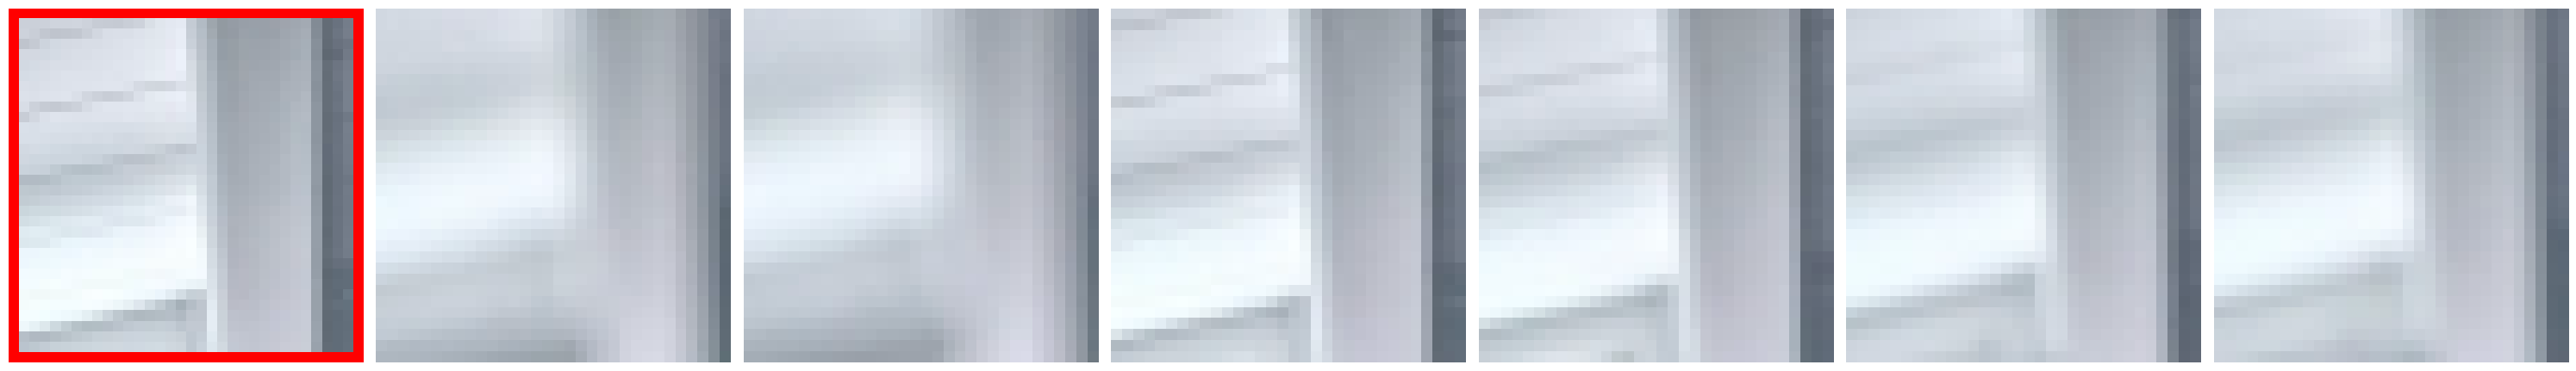

249.0
7848.568790397049


In [10]:


import os
import cv2

# Directory path where images are stored
path=super_path+'scaled_images/'+image_type

# Filename pattern to filter
filename_pattern = 'result_scaled_image_center.jpg'

# Initialize an empty list to store images
images = []

# Recursively traverse the directory tree
for root, _, files in os.walk(path):
    for filename in files:
        if filename == filename_pattern:
            # Construct the full file path
            file_path = os.path.join(root, filename)
            
            # Open the image using PIL (assuming PNG format)
            image = cv2.imread(file_path)
            
            #  the image to the list
            images.append(image)

# Now 'images' contains all images named 'result_up_pd_left_center.png' from the directory and its subfolders
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have 49 images stored in a list called images
# Each image in images should be a numpy array or a PIL Image object

# Example list of 49 images (using placeholder numpy arrays)
#images = [np.random.random((100, 100)) for _ in range(49)]

# Determine layout of subplots (7x7 grid for 49 images)
num_images = len(images)
rows = 1
cols = 7

from operator import truth
import numpy as np
import matplotlib.pyplot as plt
import cv2

truth_slice=ground_truth[image_type[:-1]]['center']
patch=patches[image_type[:-1]]['center']
patch=(patch[0],patch[1])
print(truth_slice)
print(patch)
print(images[0].shape)
images=[im[patch[0]:patch[0]+32,patch[1]:patch[1]+32] for im in images]
#images=[cv2.cvtColor(im, cv2.COLOR_BGR2RGB) for im in images]
# Parameters for border
border_color = [255, 0, 0]  # Red color in RGB
border_size = 1

def add_border(image, border_size, border_color):
    return cv2.copyMakeBorder(image, border_size, border_size, border_size, border_size, cv2.BORDER_CONSTANT, value=border_color)

# Adding border to the xth image
images[truth_slice] = add_border(images[truth_slice], border_size, border_color)

# Create a figure with 7x7 subplots
row_size=7 if truth_slice%7==0 else 8
fig, axes = plt.subplots(1, row_size, figsize=(30, 30))

truth_display=True
# Plot each image
i=0
for ax in (axes.flat):
    if (i*7)<49:
        ax.imshow(images[i*7])
    if i*7 > truth_slice and truth_slice>(i-1)*7 and truth_display:
        ax.imshow(images[truth_slice])
        i-=1
        truth_display=False
    ax.axis('off')  # Hide the axes
    i+=1

# Display the grid
plt.tight_layout()
plt.show()

depth=cv2.imread(super_path+'merged_depth/'+image_type+'result_merged_depth_center.png')
depth=depth[patch[0]:patch[0]+32,patch[1]:patch[1]+32]
med=np.median(depth)
print(med)

max_depth = 100.0
min_depth = 0.2

med = (max_depth * min_depth) / (max_depth - (max_depth - min_depth) * (med / 255.0))

print(med*1000)





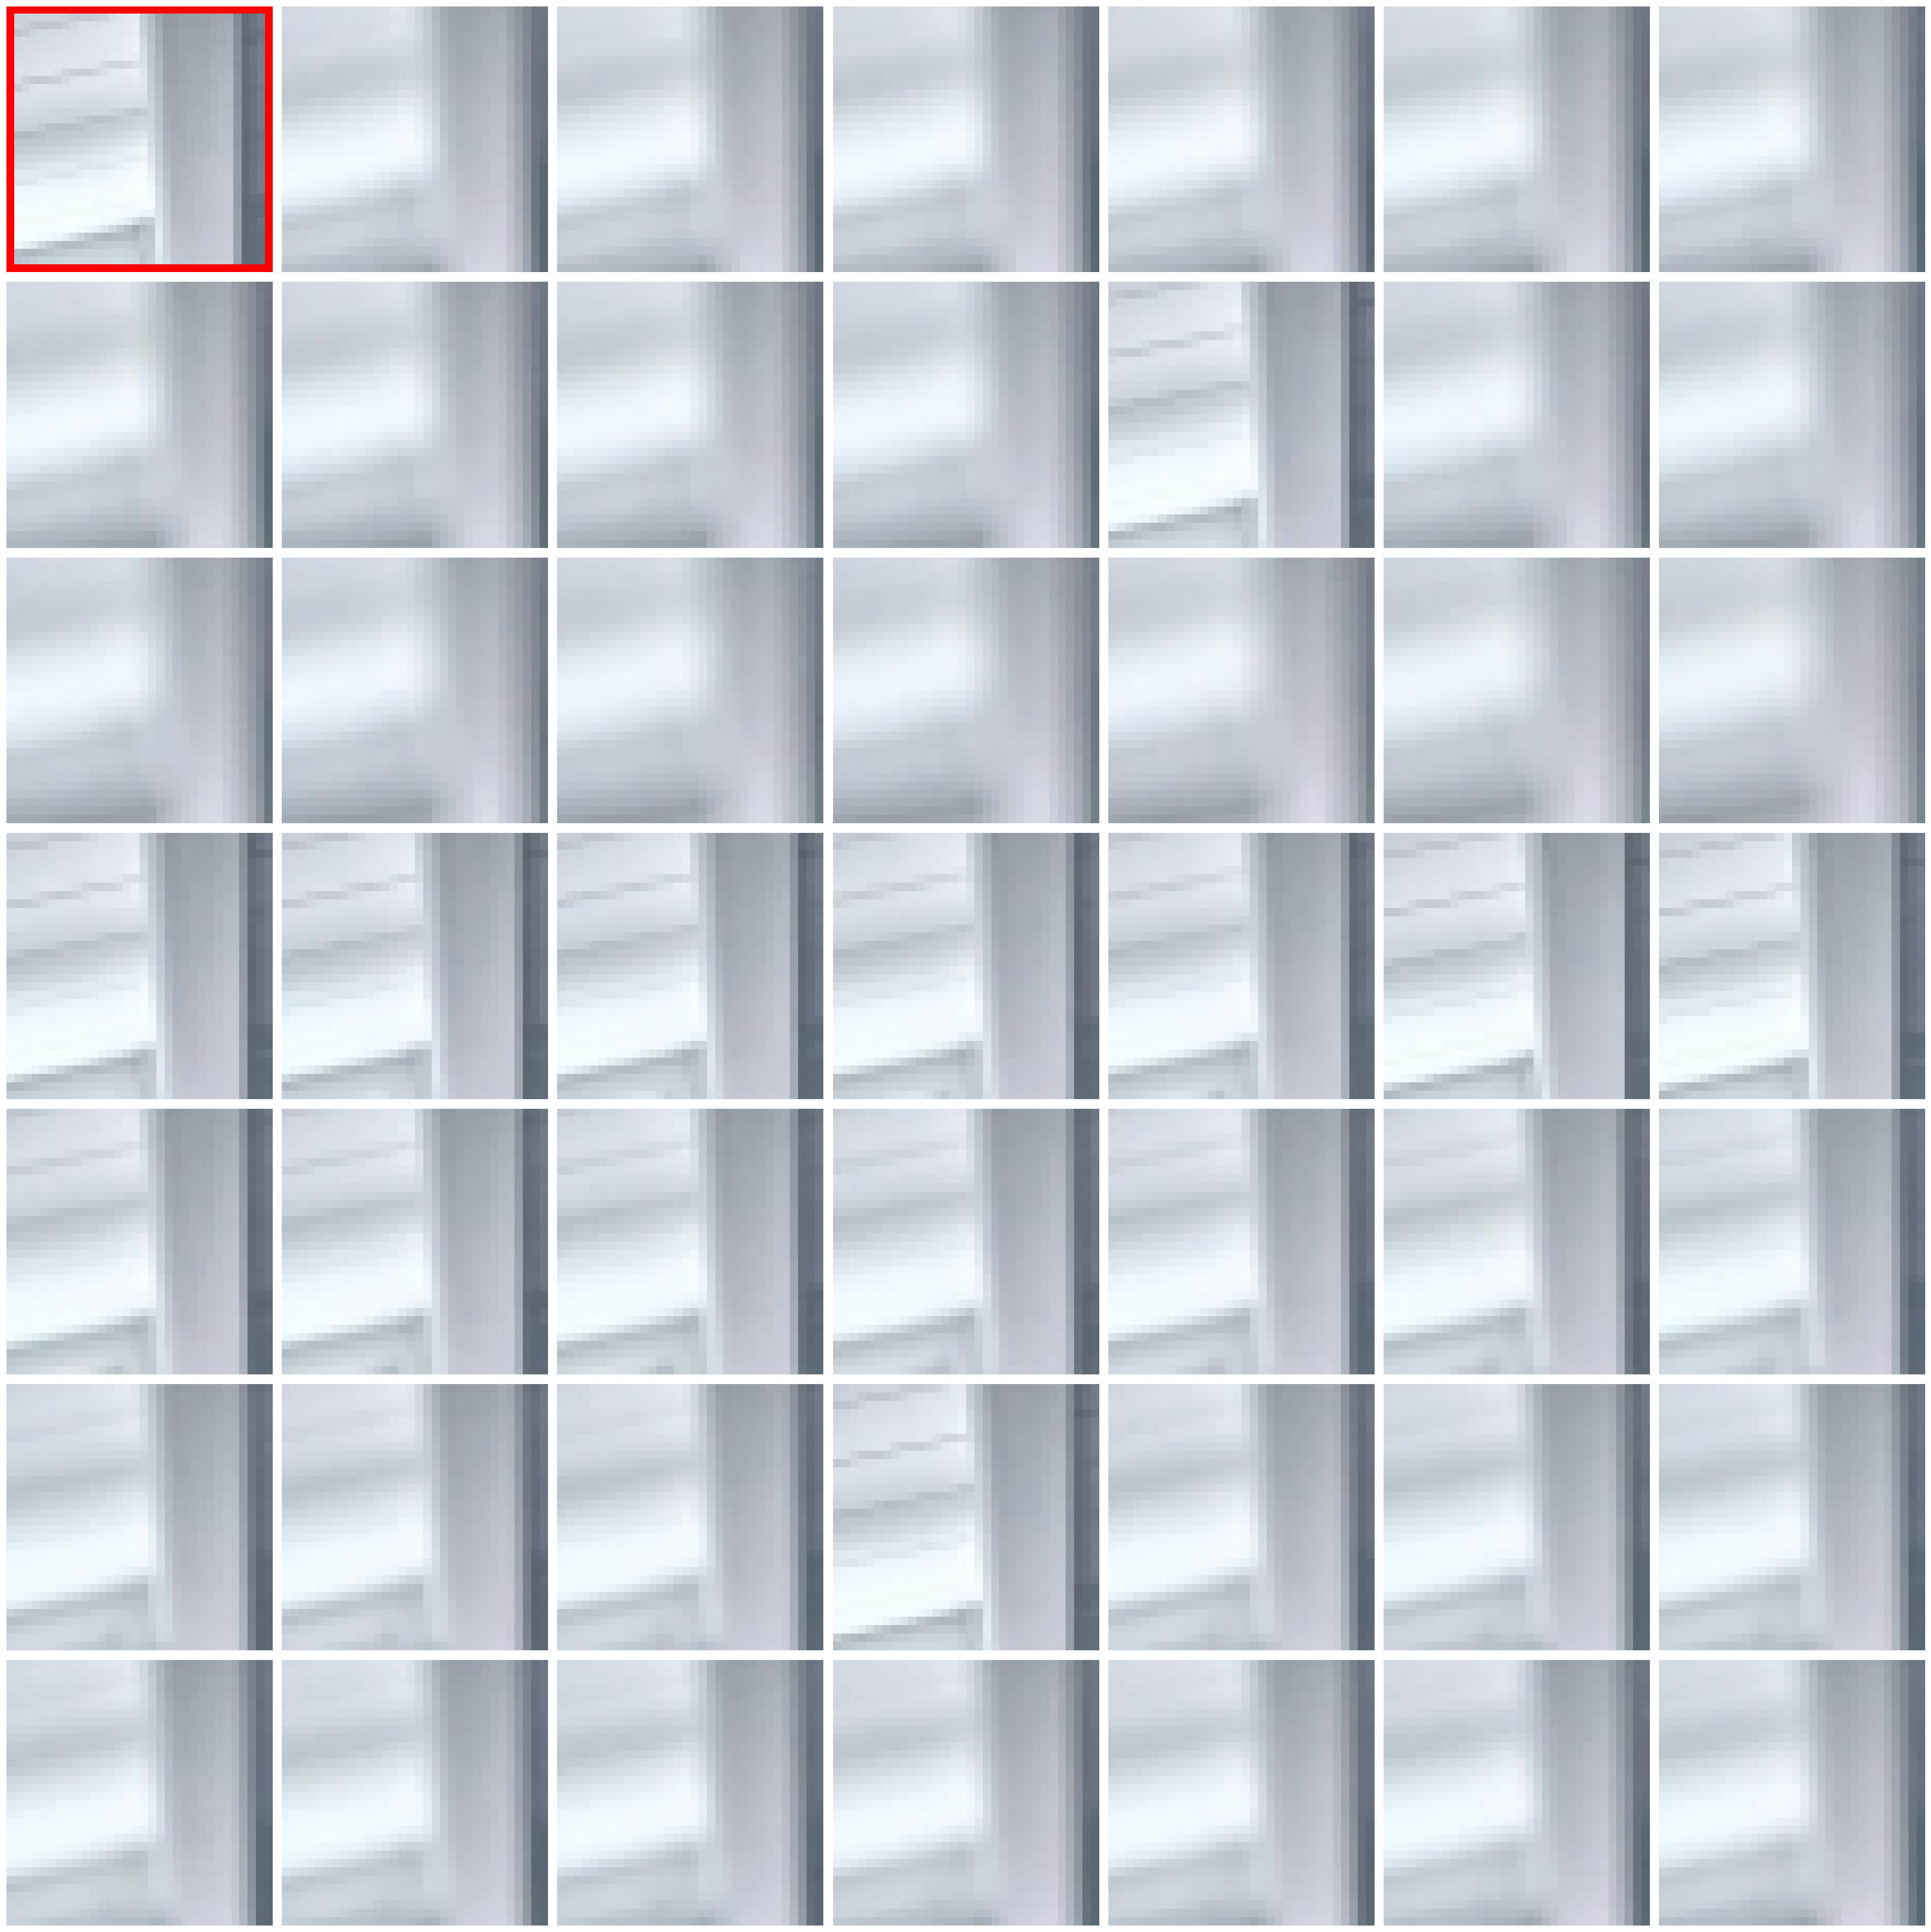

In [11]:


fig, axes = plt.subplots(7, 7, figsize=(30, 30))

i=0
for ax in (axes.flat):
    ax.imshow(images[i])
    ax.axis('off')  # Hide the axes
    i+=1

# Display the grid
plt.tight_layout()
plt.show()

